# Armstrong 1994 model

### Multiple P-Z model with variable N stock from 0 to 10

    - dPi/dt = Vi*N/(N+K)*Pi -g*Pi*Zi/Kp- lp*Pi
    - dZi/dt = a*g*Pi*Zi/Kp - lz*Zi
    - N = T - sum(Pi) - sum(Zi)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# coefficients
h = 1 # timestep size
T = 10 # total nutrient level
Ns= 4 # number of size class
inipz = .001 # initial condition for phyto and zoo
# set parameters
Vmax = 1.4 # per day
K = 0.1 # mmol/m3
Kp= 2.8 # mmol/m3
a = 0.4
g = 1.4 # per day
lp = 0.05 # per day
lz = 0.12 # per day
beta = 0.4 # allometric scaling coefficient

In [3]:
def tendency(t,x,Vmax,K,Kp,a,g,lp,lz,Ns,T,beta):
    # initialize arrays
    Ns = int(Ns)
    phy=np.zeros(Ns)
    zoo=np.zeros(Ns)
    out=np.zeros(2*Ns)
    dphydt=np.zeros(Ns)
    dzoodt=np.zeros(Ns)
    #
    for n in range(Ns):
        phy[n]=x[n]
        zoo[n]=x[Ns+n]
    nut = max(0,T - np.sum(phy) - np.sum(zoo))
    for n in range(Ns):
        L = 4**n
        V = Vmax*L**-beta
        dphydt[n] = V*nut/(nut+K)*phy[n] - zoo[n]*g*phy[n]/Kp - lp*phy[n]
        dzoodt[n] = a*zoo[n]*g*phy[n]/Kp - lz*zoo[n]
        out[n]=dphydt[n]
        out[n+Ns]=dzoodt[n]
    return out

In [4]:
# define model_run function
def model_run(trange,xinit,param,dt):
    # expand input
    Vmax = param[0]
    K = param[1]
    Kp= param[2]
    a = param[3]
    g = param[4]
    lp = param[5]
    lz = param[6]
    Ns = param[7]
    T = param[8]
    beta = param[9]
    sol = solve_ivp(tendency,trange,xinit,args=(Vmax,K,Kp,a,g,lp,lz,Ns,T,beta),method='RK45',max_step=dt)
    return sol

In [5]:
# running the model multiple times with different values of T
T_ref = np.arange(0,10,.2) # 0 to 10 for every 0.2
Nexp = np.size(T_ref) # number of integrations
# prepare arrays to store results
P=np.zeros((Ns,Nexp))
Z=np.zeros((Ns,Nexp))
N=np.zeros(Nexp,)
#
# start the main loop over different T values
Nave = 200
#
for m in range(Nexp):
    # set T value
    T = T_ref[m]
    # set time range
    trange = [0,360*5] # running for 5 years
    # set parameters
    param=np.array([Vmax,K,Kp,a,g,lp,lz,Ns,T,beta])
    # set initial conditions
    xinit = inipz*np.ones(2*Ns,)
    # time step size
    h = 1
    out = model_run(trange,xinit,param,h)
    # record the result (steady solution)
    vec_out = out.y
    Nt=np.size(out.t)
    # this part is just extracting the steady state for P, Z and N
    # and steady state is approximated as averages of last (Nave) time steps
    for n in range(Ns):
        P[n,m] = np.mean(vec_out[n,-Nave:])
        Z[n,m] = np.mean(vec_out[Ns+n,-Nave:])
    N[m] = T - np.sum(P[:,m]) - np.sum(Z[:,m])

(0.0, 10.5)

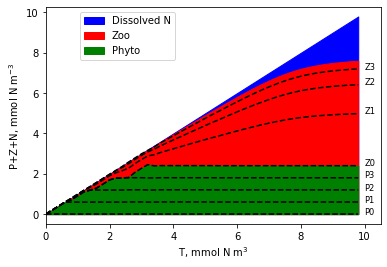

In [6]:
# plot the output
TNrange = T_ref
Z_TN = Z
P_TN = P
#
plt.fill_between(TNrange,TNrange,color='b',label='Dissolved N')
plt.fill_between(TNrange,np.sum(Z_TN[:,:],axis=0)+np.sum(P_TN[:,:],axis=0),color='r',label='Zoo')
plt.fill_between(TNrange,np.sum(P_TN[:,:],axis=0),color='g',label='Phyto')

for n in range(Ns):
    plt.plot(TNrange,np.sum(P_TN[:n,:],axis=0),'k--')
    plt.plot(TNrange,np.sum(Z_TN[:n,:],axis=0)+np.sum(P_TN[:,:],axis=0),'k--')
    Pstring='P'+str(n)
    Zstring ='Z'+str(n)
    plt.text(10,np.sum(P_TN[:n,-1:],axis=0),Pstring,fontsize='small')
    plt.text(10,np.sum(Z_TN[:n,-1:],axis=0)+np.sum(P_TN[:,-1:],axis=0),Zstring,fontsize='small')
plt.legend(bbox_to_anchor=(0.4,1))
plt.xlabel(r'T, mmol N m$^{3}$')
plt.ylabel(r'P+Z+N, mmol N m$^{-3}$')
plt.xlim([0,10.5])